In [2]:
#!pip install tqdm

import urllib.request
import zipfile
import os
from tqdm import tqdm

# Function to download a file with a progress bar
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

#url = "https://nlp.stanford.edu/data/glove.6B.zip"
#output = "glove.6B.zip"

# Download the GloVe embeddings with a progress bar
#with DownloadProgressBar(unit='B', unit_scale=True, miniters=1, desc=url.split('/')[-1]) as t:
    #urllib.request.urlretrieve(url, filename=output, reporthook=t.update_to)


# Unzip the downloaded file
#with zipfile.ZipFile(output, 'r') as zip_ref:
    #zip_ref.extractall()

# Ensure gensim is installed
#!pip install gensim

# Import KeyedVectors from gensim and load the word vectors
from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format('glove.6B.50d.txt', binary=False, no_header=True)

In [3]:
#!pip install ipdb
#!pip install torch torch-geometric
#!pip install pandas
#!pip install scikit-learn
#!pip install matplotlib

import pandas as pd
import os
from collections import defaultdict, Counter
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import ipdb



from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.optim import Adam
from torch.nn.functional import cross_entropy
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_auc_score, r2_score, mean_squared_error
from sklearn.utils.class_weight import compute_class_weight
torch.manual_seed(42)

In [53]:
!unzip drive/MyDrive/slt_challenge/transcripts_outputFiles.zip


'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
def load_graph_info(nodes_degree_txt, nodes_edges_txt):
  nodes_features = defaultdict(dict)
  edges = []
  with open(nodes_degree_txt, 'r') as nodes_degree_file, open(nodes_edges_txt, 'r') as nodes_edges_file:
      reading_nodes, reading_edges = False, False

      for line in nodes_edges_file:
          line = line.strip()
          if (not line) or line.startswith("id*int") or line.startswith("source*int"):
              continue

          if line.startswith("*Nodes"):
              # start reading node info
              reading_nodes = True
              reading_edges = False
          elif line.startswith("*DirectedEdges"):
              # start reading edge info
              reading_nodes = False
              reading_edges = True

          elif reading_nodes:
            # parse node info
              parts = line.split(" ", 2)
              node_id = int(parts[0])
              label = parts[1].strip('"')
              nodes_features[node_id]['label'] = label


          elif reading_edges:
            # parse edge info
              parts = line.split()
              source = int(parts[0])
              target = int(parts[1])
              edges.append((source, target))

      for line in nodes_degree_file:
        line = line.strip()
        if (not line) or (not line.startswith("Node Degree")):
          parts = line.split()
          node_id = int(parts[0])
          degree = parts[1].strip('"')
          nodes_features[node_id]['degree'] = degree

      # print(len(nodes_features), len(edges))
      return nodes_features, edges


def get_word_embedding(word, embedding_dim=50):
    try:
        return torch.tensor(word_vectors[word], dtype=torch.float)
    except KeyError:
        # for words not in the vocabulary, use a zero vector
        # print('WARNING: word not in the vocabulary: ', word)
        return torch.zeros(embedding_dim)


def prep_data_for_gnn(nodes_features, edges):
    # mapping from node ID to index
    node_id_to_index = {node_id: i for i, node_id in enumerate(nodes_features.keys())}

    # create node features: node degrees and word embeddings)
    features = []
    for node_id in nodes_features.keys():
        node_label = nodes_features[node_id]['label']
        node_embeddings = get_word_embedding(node_label)
        # print(node_id,nodes_features[node_id]['degree'])
        # new_value = torch.tensor([15], dtype=torch.int64)
        # tensor = torch.cat((node_embeddings, new_value))

        features.append(node_embeddings)
    #pca = PCA(n_components=pca_components)
    #reduced_features = pca.fit_transform(features)  
    #x = torch.tensor(reduced_features, dtype=torch.float32) 
    x = torch.stack(features) 

    # create edge index tensor
    edge_index = torch.tensor(
        [[node_id_to_index[src], node_id_to_index[dst]] for src, dst in edges],
        dtype=torch.long,
    ).t().contiguous()
    return x, edge_index


def get_datalist(id_list, label_list, transcript_folder):
  """
  returns a list of Data objects
  """
  data_list = []
  id_label_list = [(id, label) for id, label in zip(id_list, label_list)]
  for id, label in id_label_list:
    filepath = os.path.join(transcript_folder, id)
    nodes_features, edges = load_graph_info(f'{filepath}_dir_nodes_degree.txt', f'{filepath}_dir_nodes_edges.txt')
    x, edge_index = prep_data_for_gnn(nodes_features, edges)
    graph_data = Data(x=x, edge_index=edge_index, y=torch.tensor([label], dtype=torch.long))
    data_list.append(graph_data)
  return data_list


def get_dataloader(data_list, batch_size=None):
  if not batch_size:
    batch_size = len(data_list)
    print('Setting batch size to ', batch_size)
  return DataLoader(data_list, batch_size=batch_size, shuffle=False)

def calculate_class_weights(labels):
    class_weights = compute_class_weight(
        class_weight = 'balanced',
        classes = np.unique(labels),
        y = labels)
   
    return torch.tensor(class_weights, dtype=torch.float)
   


class GNNClassifier(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNClassifier, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x


def train_gnn(train_datalist, train_batch_size=None, hidden_dim=64, lr=0.01, epoches=250, class_weights=None, num_classes = 2):
  torch.manual_seed(42)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  train_dataloader = get_dataloader(train_datalist, batch_size=train_batch_size)

  num_node_features = next(iter(train_dataloader)).x.size(1)

  model = GNNClassifier(input_dim=num_node_features, hidden_dim=hidden_dim, output_dim=num_classes).to(device)
  optimizer = Adam(model.parameters(), lr=lr)

  if class_weights is not None:
      class_weights = class_weights.to(device) 
  loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
  for epoch in range(epoches):
      model.train()
      total_loss = 0

      for batch in train_dataloader:
          batch = batch.to(device)
          optimizer.zero_grad()
          out = model(batch)
          loss = loss_fn(out, batch.y)
          loss.backward()
          optimizer.step()
          total_loss += loss.item()

      if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.5f}')

  return model


def eval_gnn(model, eval_datalist, stage_labels=None, print_results=True, batch_size=None):
    model.eval()
    logits_list, pred_list, y_list = [], [], []
    eval_dataloader = get_dataloader(eval_datalist, batch_size=batch_size)
    for batch in eval_dataloader:
        logits = model(batch)
        pred = logits.argmax(dim=1)
        logits_list.append(logits)
        pred_list.append(pred)
        y_list.append(batch.y)
    # concatenate data from all batches
    logits_all = torch.cat(logits_list, dim=0)
    pred_all = torch.cat(pred_list, dim=0)
    y_all = torch.cat(y_list, dim=0)
    # get metrics
    results, disp = calc_metrics(y_all, pred_all, display_labels=stage_labels)
    return logits_all, pred_all, results, disp

def calc_metrics(actual_labels, pred_vals, display_labels=None, print_results=True):
    results = {
        'accuracy': accuracy_score(actual_labels, pred_vals),
        'f1': f1_score(actual_labels, pred_vals, average='macro'),
        'precision': precision_score(actual_labels, pred_vals, average='macro'),
        'recall': recall_score(actual_labels, pred_vals, average='macro')
    }

    cm = confusion_matrix(actual_labels, pred_vals)

    # Get only the unique classes present in the actual predictions
    unique_classes = np.unique(np.concatenate([actual_labels, pred_vals]))  
    if display_labels is None:
        display_labels = [str(label) for label in unique_classes]  # Ensure matching labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

    if print_results:
        for metric, value in results.items():
            print(f'{metric}: {value:.3f}')
        disp.plot()
        plt.show()

    return results, disp


class NNMetaModel(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
      super().__init__()
      self.fc1 = Linear(input_dim, hidden_dim)
      self.fc2 = Linear(hidden_dim, output_dim)

  def forward(self, x):
      x = self.fc1(x)
      x = x.relu()
      x = self.fc2(x)
      return x

def train_nn_metamodel(features, labels, epochs=50, hidden_dim=32, lr=0.01, n_tasks=3):
    num_classes = len(torch.unique(labels))
    input_dim = features.shape[1]
    model = NNMetaModel(input_dim, hidden_dim=hidden_dim, output_dim=num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(features)
        loss = cross_entropy(output, labels)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')
    return model


Fold 0:

    train set for base model: 100 samples; label count: Counter({0: 52, 1: 38, 2: 10}),
    train set for meta model: 25 samples; label count: Counter({0: 13, 1: 10, 2: 2}),
    dev set for meta model: 32 samples; label count: Counter({0: 17, 1: 11, 2: 4})
----------- Task: CTD -----------
Training base model train set + meta model train set...
Setting batch size to  125
Epoch 0, Loss: 0.69260
Epoch 50, Loss: 0.10494
Epoch 100, Loss: 0.00087
Epoch 150, Loss: 0.00040
Epoch 200, Loss: 0.00024
Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.844
f1: 0.458
precision: 0.435
recall: 0.482


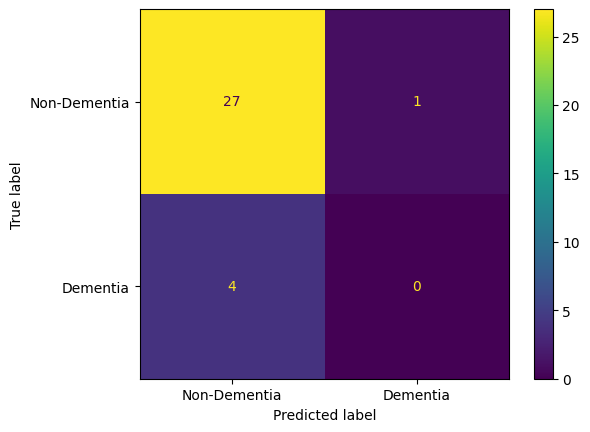

<class 'pandas.core.series.Series'>
<class 'torch.Tensor'>
Training base model for Healthy vs. MCI (Stage 2)...
Setting batch size to  113
Epoch 0, Loss: 0.69673
Epoch 50, Loss: 0.41367


KeyboardInterrupt: 

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Config Experiment
config = {
    "tasks": ['CTD', 'SFT', 'PFT'],
    "num_folds": 5,
    "random_state": 42,
    "label_mapping_stage1": {0: 0, 1: 0, 2: 1},
    "label_mapping_stage2": {'HC': 0, 'MCI': 1},
    "label_mapping_non_cascaded": {'HC': 0, 'MCI': 1, 'Dementia': 2}
}

# Load metadata
metadata = pd.read_csv("PROCESS_METADATA_ALL.csv")
metadata = metadata.sample(frac=1, random_state=config['random_state'], ignore_index=False)
metadata['diagnosis_coded'] = metadata['diagnosis'].map(config['label_mapping_non_cascaded'])
df_traindev = metadata[metadata['Tr/Tt/Dv'].isin(['train', 'dev'])]
id_traindev, label_traindev = df_traindev['anyon_IDs'], df_traindev['diagnosis_coded']

skf = StratifiedKFold(n_splits=config["num_folds"], shuffle=True, random_state=config['random_state'])

all_preds = defaultdict(lambda: {"Stage1": [], "Stage2": [], "Overall": []})
all_trues = defaultdict(lambda: {"Stage1": [], "Stage2": [], "Overall": []})

# Split data into train and dev sets for each fold
for fold_index, (train_index, dev_index) in enumerate(skf.split(id_traindev, label_traindev)):
    print(f"Fold {fold_index}:")
    base_train_id, ensemble_train_id, base_train_label, ensemble_train_label = train_test_split(id_traindev[train_index], label_traindev[train_index],
                                                        stratify=label_traindev[train_index],
                                                        test_size=0.2)
    
    print(f'''
    train set for base model: {len(base_train_label)} samples; label count: {Counter(base_train_label)},
    train set for meta model: {len(ensemble_train_label)} samples; label count: {Counter(ensemble_train_label)},
    dev set for meta model: {len(label_traindev[dev_index])} samples; label count: {Counter(label_traindev[dev_index])}''')

    # Prepare labels for stage 1 and stage 2
    base_train_label_stage1 = base_train_label.map(config['label_mapping_stage1'])
    ensemble_train_label_stage1 = ensemble_train_label.map(config['label_mapping_stage1'])
    label_traindev_stage1_dev = label_traindev[dev_index].map(config['label_mapping_stage1'])

    base_train_label_stage2 = base_train_label[base_train_label != 2]
    ensemble_train_label_stage2 = ensemble_train_label[ensemble_train_label != 2]
    label_traindev_stage2_dev = label_traindev[dev_index][label_traindev[dev_index] != 2]

    # Identify data samples for stage 2
    base_train_id_stage2 = base_train_id[base_train_label != 2]
    ensemble_train_id_stage2 = ensemble_train_id[ensemble_train_label != 2]
    id_traindev_stage2_dev = id_traindev[dev_index][label_traindev[dev_index] != 2]

    # Train and evaluate models for each task
    for task in config['tasks']:
        print(f'----------- Task: {task} -----------')
        transcript_folder = os.path.join("transcripts_outputFiles", f"{task}_outputFiles")
        if not os.path.exists(transcript_folder):
            os.makedirs(transcript_folder)

        # Prepare data, calculate class weights, and train models for stage 1
        base_train_datalist_stage1 = get_datalist(base_train_id, base_train_label_stage1, transcript_folder)
        ensemble_train_datalist_stage1 = get_datalist(ensemble_train_id, ensemble_train_label_stage1, transcript_folder)
        ensemble_dev_datalist_stage1 = get_datalist(id_traindev[dev_index], label_traindev_stage1_dev[dev_index], transcript_folder)

        combined_labels_stg1 = np.concatenate([base_train_label_stage1, ensemble_train_label_stage1])
        class_weights_stg1 = calculate_class_weights(combined_labels_stg1)

        print('Training base model train set + meta model train set...')
        trained_gnn_stage1 = train_gnn(base_train_datalist_stage1 + ensemble_train_datalist_stage1, class_weights=class_weights_stg1)
        
        print('Validating on meta model dev set...')
        _, task_pred_ensemble_validation, _, _ = eval_gnn(trained_gnn_stage1, ensemble_dev_datalist_stage1, stage_labels= ['Non-Dementia', 'Dementia'], print_results=False)
        print(type(label_traindev[dev_index]))
        print(type(task_pred_ensemble_validation))
        all_preds[task]["Stage1"].extend(task_pred_ensemble_validation.tolist())
        all_trues[task]["Stage1"].extend(label_traindev_stage1_dev.tolist())

        # Prepare data, calculate class weights, and train models for stage 2
        healthy_train_datalist = get_datalist(base_train_id_stage2, base_train_label_stage2, transcript_folder)
        healthy_ensemble_train_datalist = get_datalist(ensemble_train_id_stage2, ensemble_train_label_stage2, transcript_folder)

        print('Training base model for Healthy vs. MCI (Stage 2)...')
        combined_labels_stg2 = np.concatenate([base_train_label_stage2, ensemble_train_label_stage2])
        class_weights_stg2 = calculate_class_weights(combined_labels_stg2)
        trained_gnn_stage2 = train_gnn(healthy_train_datalist + healthy_ensemble_train_datalist, class_weights=class_weights_stg2)

        print('Validating Stage 2 model on meta model dev set...')
        # Get samples and labels for predicted healthy individuals in stage 1
        predicted_healthy_dev_indices = [i for i, pred in enumerate(task_pred_ensemble_validation) if pred == 0]
    
        predicted_healthy_dev_ids = []
        predicted_healthy_dev_labels = []

        dementia_misclassifications_dev = 0

        for i in predicted_healthy_dev_indices:
            label = label_traindev[dev_index].iloc[i]
            if label != 2:
                predicted_healthy_dev_ids.append(id_traindev[dev_index].iloc[i])
                predicted_healthy_dev_labels.append(label)
            else:
                dementia_misclassifications_dev += 1

        predicted_healthy_dev_datalist = get_datalist(predicted_healthy_dev_ids, predicted_healthy_dev_labels, transcript_folder)

        _, task_pred_stage2_dev, results_dict, _ = eval_gnn(trained_gnn_stage2, predicted_healthy_dev_datalist, stage_labels=['HC', 'MCI'])

        print(type(predicted_healthy_dev_ids))
        print(type(task_pred_stage2_dev))
        task_pred_stage2_dev = task_pred_stage2_dev if isinstance(task_pred_stage2_dev, list) else task_pred_stage2_dev.tolist()
        
        all_preds[task]["Stage2"].extend(task_pred_stage2_dev)
        all_trues[task]["Stage2"].extend(predicted_healthy_dev_labels)

        # Calculate overall performance on ensemble development set

        combined_predictions_ensemble_dev = []

        stage2_predictions_dev_dict = dict(zip(predicted_healthy_dev_ids, task_pred_stage2_dev))

        for i, id_value in enumerate(id_traindev[dev_index]):
            if task_pred_ensemble_validation[i] == 0: 
                if id_value in stage2_predictions_dev_dict:
                    if stage2_predictions_dev_dict[id_value] == 0:
                        combined_predictions_ensemble_dev.append('HC')
                    else:
                        combined_predictions_ensemble_dev.append('MCI')
                else:
                    combined_predictions_ensemble_dev.append('Unknown_Non_Dementia')
            else:  # Stage 1 predicted Dementia
                combined_predictions_ensemble_dev.append('Dementia')

        actual_labels_ensemble_dev = label_traindev[dev_index].map({0: 'HC', 1: 'MCI', 2: 'Dementia'})

        all_preds[task]["Overall"].extend(combined_predictions_ensemble_dev)
        all_trues[task]["Overall"].extend(actual_labels_ensemble_dev.tolist())

# Print results of GNN for each task and stage

for task in all_preds.keys():
    for stages in all_preds[task].keys():
        print(f'\n----------- Task: {task} -----------\n-----------{stages} -----------')
        print(classification_report(all_trues[task][stages], all_preds[task][stages]))
    